Time series prediction 

The particular network architecture we will employ for our RNN is known as  [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.  

## 1.1 Getting started

First we must load in our time series - a history of around 140 days of Apple's stock price.  Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), but it is also commonplace to normalize by a series standard deviation.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

dataset = np.loadtxt('datasets/apple_prices.csv')

Lets take a quick look at the time series we'll be performing predictions on.

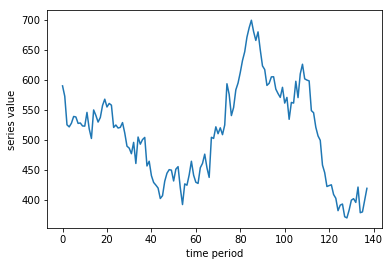

In [2]:
# lets take a look at our time series
plt.plot(dataset)
plt.xlabel('time period')
plt.ylabel('series value')

### TODO: Normalize time series and plot it again

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (-1,1))
dataset = scaler.fit_transform(dataset.reshape(dataset.shape[0],1))

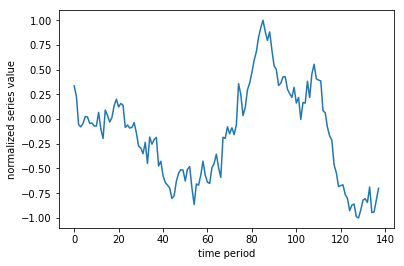

In [4]:
# lets take a look at our time series
plt.plot(dataset)
plt.xlabel('time period')
plt.ylabel('normalized series value')

## 1.2  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at
time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="images\timeseries_windowing_training.gif" width=600 height=600/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 4 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now its time for you to window the input time series as described above!  

<a id='TODO_1'></a>

**TODO:** Fill in the function below - called **window_transform_series** - that runs a sliding window along the input series and creates associated input/output pairs.    Note that this function should input a) the series and b) the window length, and return the input/output subsequences.  Make sure to format returned input/output as generally shown in table above (where window_size = 5), and make sure your returned input is a numpy array.

-----

In [5]:
### TODO: fill out the function below that transforms the input series and window-size into a set of input/output pairs for use with our RNN model
def window_transform_series(series, window_size):
    # containers for input/output pairs
    X = []
    y = []
    for i in range(len(series)-window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    
        
    # reshape each 
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),1)
    
    return X,y

You can test your function on the list of odd numbers given below

In [6]:
odd_nums = np.array([1,3,5,7,9,11,13])

# run a window of size 2 over the odd number sequence and display the results
window_size = 2
X,y = window_transform_series(odd_nums,window_size)

# print out input/output pairs --> here input = X, corresponding output = y
print ('--- the input X will look like ----')
print (X)

print ('--- the associated output y will look like ----')
print (y)

print ('the shape of X is ' + str(np.shape(X)))
print ('the shape of y is ' + str(np.shape(y)))
print('the type of X is ' + str(type(X)))
print('the type of y is ' + str(type(y)))

--- the input X will look like ----
[[ 1  3]
 [ 3  5]
 [ 5  7]
 [ 7  9]
 [ 9 11]]
--- the associated output y will look like ----
[[ 5]
 [ 7]
 [ 9]
 [11]
 [13]]
the shape of X is (5, 2)
the shape of y is (5, 1)
the type of X is <class 'numpy.ndarray'>
the type of y is <class 'numpy.ndarray'>


With this function in place apply it to the series in the Python cell below.  We use a window_size = 7 for these experiments.

In [7]:
# window the data using your windowing function
window_size = 7
X,y = window_transform_series(series = dataset,window_size = window_size)

## 1.3  Splitting into training and testing sets

In order to perform proper testing on our dataset we will lop off the last 1/3 of it for validation (or testing).  This is that once we train our model we have something to test it on (like any regression problem!).  This splitting into training/testing sets is done in the cell below.

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how we would predict *future* values of a time series.

In [8]:
# split our dataset into training / testing sets
train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point

# partition the training set
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

<a id='TODO_2'></a>

## 1.4  Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used (remember: we are performing regression here)

This can be constructed using just a few lines - see e.g., the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/) and the [LTSM documentation in particular](https://keras.io/layers/recurrent/) for examples of how to quickly use Keras to build neural network models.  Make sure you are initializing your optimizer given the [keras-recommended approach for RNNs](https://keras.io/optimizers/) 

In [ ]:
### TODO: create required RNN model
# import keras network libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

# given - fix random seed - so we can all reproduce the same results on our default time series
np.random.seed(0)


# TODO: build an RNN to perform regression on our time series input/output data
model = Sequential()
model.add(LSTM(5, input_shape=(window_size,1)))
model.add(Dense(1))


# build model using keras documentation recommended optimizer initialization
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer)

C:\Users\Marina\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
# run your model!
model.fit(X_train, y_train, epochs=1000, batch_size=50, verbose=1)

Epoch 1/1000
88/88 [==============================] - 1s 10ms/step - loss: 0.1018
Epoch 2/1000
88/88 [==============================] - 0s 193us/step - loss: 0.0962
Epoch 3/1000
88/88 [==============================] - 0s 215us/step - loss: 0.0925
Epoch 4/1000
88/88 [==============================] - 0s 204us/step - loss: 0.0897
Epoch 5/1000
88/88 [==============================] - 0s 197us/step - loss: 0.0871
Epoch 6/1000
88/88 [==============================] - 0s 181us/step - loss: 0.0847
Epoch 7/1000
88/88 [==============================] - 0s 178us/step - loss: 0.0825
Epoch 8/1000
88/88 [==============================] - 0s 182us/step - loss: 0.0804
Epoch 9/1000
88/88 [==============================] - 0s 193us/step - loss: 0.0784
Epoch 10/1000
88/88 [==============================] - 0s 204us/step - loss: 0.0767
Epoch 11/1000
88/88 [==============================] - 0s 165us/step - loss: 0.0747
Epoch 12/1000
88/88 [==============================] - 0s 192us/step - loss: 0.0728
Ep

88/88 [==============================] - 0s 170us/step - loss: 0.0269
Epoch 99/1000
88/88 [==============================] - 0s 227us/step - loss: 0.0269
Epoch 100/1000
88/88 [==============================] - 0s 170us/step - loss: 0.0267
Epoch 101/1000
88/88 [==============================] - 0s 238us/step - loss: 0.0267
Epoch 102/1000
88/88 [==============================] - 0s 147us/step - loss: 0.0265
Epoch 103/1000
88/88 [==============================] - 0s 170us/step - loss: 0.0264
Epoch 104/1000
88/88 [==============================] - 0s 215us/step - loss: 0.0264
Epoch 105/1000
88/88 [==============================] - 0s 195us/step - loss: 0.0265
Epoch 106/1000
88/88 [==============================] - 0s 189us/step - loss: 0.0262
Epoch 107/1000
88/88 [==============================] - 0s 179us/step - loss: 0.0261
Epoch 108/1000
88/88 [==============================] - 0s 193us/step - loss: 0.0261
Epoch 109/1000
88/88 [==============================] - 0s 204us/step - loss: 0.0

88/88 [==============================] - 0s 193us/step - loss: 0.0204
Epoch 195/1000
88/88 [==============================] - 0s 193us/step - loss: 0.0200
Epoch 196/1000
88/88 [==============================] - 0s 185us/step - loss: 0.0200
Epoch 197/1000
88/88 [==============================] - 0s 261us/step - loss: 0.0199
Epoch 198/1000
88/88 [==============================] - 0s 204us/step - loss: 0.0198
Epoch 199/1000
88/88 [==============================] - 0s 193us/step - loss: 0.0198
Epoch 200/1000
88/88 [==============================] - 0s 189us/step - loss: 0.0197
Epoch 201/1000
88/88 [==============================] - 0s 227us/step - loss: 0.0198
Epoch 202/1000
88/88 [==============================] - 0s 193us/step - loss: 0.0197
Epoch 203/1000
88/88 [==============================] - 0s 193us/step - loss: 0.0196
Epoch 204/1000
88/88 [==============================] - 0s 196us/step - loss: 0.0196
Epoch 205/1000
88/88 [==============================] - 0s 193us/step - loss: 0.

88/88 [==============================] - 0s 182us/step - loss: 0.0166
Epoch 291/1000
88/88 [==============================] - 0s 198us/step - loss: 0.0166
Epoch 292/1000
88/88 [==============================] - 0s 227us/step - loss: 0.0165
Epoch 293/1000
88/88 [==============================] - 0s 194us/step - loss: 0.0166
Epoch 294/1000
88/88 [==============================] - 0s 240us/step - loss: 0.0165
Epoch 295/1000
88/88 [==============================] - 0s 204us/step - loss: 0.0164
Epoch 296/1000
88/88 [==============================] - 0s 170us/step - loss: 0.0164
Epoch 297/1000
88/88 [==============================] - 0s 193us/step - loss: 0.0164
Epoch 298/1000
88/88 [==============================] - 0s 238us/step - loss: 0.0164
Epoch 299/1000
88/88 [==============================] - 0s 193us/step - loss: 0.0164
Epoch 300/1000
88/88 [==============================] - 0s 201us/step - loss: 0.0165
Epoch 301/1000
88/88 [==============================] - 0s 194us/step - loss: 0.

Epoch 386/1000
88/88 [==============================] - 0s 181us/step - loss: 0.0159
Epoch 387/1000
88/88 [==============================] - 0s 159us/step - loss: 0.0158
Epoch 388/1000
88/88 [==============================] - 0s 215us/step - loss: 0.0158
Epoch 389/1000
88/88 [==============================] - ETA: 0s - loss: 0.014 - 0s 225us/step - loss: 0.0159
Epoch 390/1000
88/88 [==============================] - 0s 218us/step - loss: 0.0159
Epoch 391/1000
88/88 [==============================] - 0s 193us/step - loss: 0.0158
Epoch 392/1000
88/88 [==============================] - 0s 204us/step - loss: 0.0158
Epoch 393/1000
88/88 [==============================] - 0s 177us/step - loss: 0.0158
Epoch 394/1000
88/88 [==============================] - 0s 191us/step - loss: 0.0159
Epoch 395/1000
88/88 [==============================] - 0s 215us/step - loss: 0.0159
Epoch 396/1000
88/88 [==============================] - 0s 193us/step - loss: 0.0157
Epoch 397/1000
88/88 [===================

88/88 [==============================] - 0s 174us/step - loss: 0.0155
Epoch 482/1000
88/88 [==============================] - 0s 159us/step - loss: 0.0155
Epoch 483/1000
88/88 [==============================] - 0s 193us/step - loss: 0.0156
Epoch 484/1000
88/88 [==============================] - 0s 188us/step - loss: 0.0156
Epoch 485/1000
88/88 [==============================] - 0s 197us/step - loss: 0.0156
Epoch 486/1000
88/88 [==============================] - 0s 193us/step - loss: 0.0156
Epoch 487/1000
88/88 [==============================] - 0s 172us/step - loss: 0.0155
Epoch 488/1000
88/88 [==============================] - 0s 183us/step - loss: 0.0156
Epoch 489/1000
88/88 [==============================] - 0s 159us/step - loss: 0.0156
Epoch 490/1000
88/88 [==============================] - 0s 181us/step - loss: 0.0155
Epoch 491/1000
88/88 [==============================] - 0s 181us/step - loss: 0.0157
Epoch 492/1000
88/88 [==============================] - 0s 193us/step - loss: 0.

88/88 [==============================] - 0s 163us/step - loss: 0.0154
Epoch 578/1000
88/88 [==============================] - 0s 170us/step - loss: 0.0154
Epoch 579/1000
88/88 [==============================] - 0s 174us/step - loss: 0.0155
Epoch 580/1000
88/88 [==============================] - 0s 216us/step - loss: 0.0153
Epoch 581/1000
88/88 [==============================] - 0s 184us/step - loss: 0.0153
Epoch 582/1000
88/88 [==============================] - 0s 170us/step - loss: 0.0154
Epoch 583/1000
88/88 [==============================] - 0s 223us/step - loss: 0.0155
Epoch 584/1000
88/88 [==============================] - 0s 193us/step - loss: 0.0156
Epoch 585/1000
88/88 [==============================] - 0s 214us/step - loss: 0.0154
Epoch 586/1000
88/88 [==============================] - 0s 181us/step - loss: 0.0156
Epoch 587/1000
88/88 [==============================] - 0s 183us/step - loss: 0.0153
Epoch 588/1000
88/88 [==============================] - 0s 191us/step - loss: 0.

Epoch 673/1000
88/88 [==============================] - 0s 176us/step - loss: 0.0153
Epoch 674/1000
88/88 [==============================] - 0s 204us/step - loss: 0.0152
Epoch 675/1000
88/88 [==============================] - 0s 178us/step - loss: 0.0154
Epoch 676/1000
88/88 [==============================] - 0s 193us/step - loss: 0.0154
Epoch 677/1000
88/88 [==============================] - 0s 181us/step - loss: 0.0153
Epoch 678/1000
88/88 [==============================] - 0s 193us/step - loss: 0.0155
Epoch 679/1000
88/88 [==============================] - 0s 210us/step - loss: 0.0154
Epoch 680/1000
88/88 [==============================] - 0s 189us/step - loss: 0.0154
Epoch 681/1000
88/88 [==============================] - 0s 183us/step - loss: 0.0153
Epoch 682/1000
88/88 [==============================] - 0s 204us/step - loss: 0.0152
Epoch 683/1000
88/88 [==============================] - 0s 170us/step - loss: 0.0153
Epoch 684/1000
88/88 [==============================] - 0s 193us/

88/88 [==============================] - 0s 181us/step - loss: 0.0152
Epoch 770/1000
88/88 [==============================] - 0s 181us/step - loss: 0.0152
Epoch 771/1000
88/88 [==============================] - 0s 181us/step - loss: 0.0152
Epoch 772/1000
88/88 [==============================] - 0s 193us/step - loss: 0.0152
Epoch 773/1000
88/88 [==============================] - 0s 215us/step - loss: 0.0156
Epoch 774/1000
88/88 [==============================] - 0s 177us/step - loss: 0.0152
Epoch 775/1000
88/88 [==============================] - 0s 171us/step - loss: 0.0152
Epoch 776/1000
88/88 [==============================] - 0s 197us/step - loss: 0.0152
Epoch 777/1000
88/88 [==============================] - 0s 159us/step - loss: 0.0153
Epoch 778/1000
88/88 [==============================] - 0s 192us/step - loss: 0.0152
Epoch 779/1000
88/88 [==============================] - 0s 204us/step - loss: 0.0152
Epoch 780/1000
88/88 [==============================] - 0s 215us/step - loss: 0.

88/88 [==============================] - 0s 159us/step - loss: 0.0151
Epoch 866/1000
88/88 [==============================] - 0s 184us/step - loss: 0.0153
Epoch 867/1000
88/88 [==============================] - 0s 219us/step - loss: 0.0152
Epoch 868/1000
88/88 [==============================] - 0s 183us/step - loss: 0.0154
Epoch 869/1000
88/88 [==============================] - 0s 181us/step - loss: 0.0151
Epoch 870/1000
88/88 [==============================] - 0s 182us/step - loss: 0.0152
Epoch 871/1000
88/88 [==============================] - 0s 181us/step - loss: 0.0154
Epoch 872/1000
88/88 [==============================] - 0s 193us/step - loss: 0.0152
Epoch 873/1000
88/88 [==============================] - 0s 204us/step - loss: 0.0151
Epoch 874/1000
88/88 [==============================] - 0s 192us/step - loss: 0.0152
Epoch 875/1000
88/88 [==============================] - 0s 181us/step - loss: 0.0154
Epoch 876/1000
88/88 [==============================] - 0s 187us/step - loss: 0.

88/88 [==============================] - 0s 229us/step - loss: 0.0151
Epoch 961/1000
88/88 [==============================] - 0s 249us/step - loss: 0.0152
Epoch 962/1000
88/88 [==============================] - 0s 238us/step - loss: 0.0152
Epoch 963/1000
88/88 [==============================] - 0s 255us/step - loss: 0.0151
Epoch 964/1000
88/88 [==============================] - 0s 265us/step - loss: 0.0152
Epoch 965/1000
88/88 [==============================] - 0s 184us/step - loss: 0.0151
Epoch 966/1000
88/88 [==============================] - 0s 215us/step - loss: 0.0151
Epoch 967/1000
88/88 [==============================] - 0s 204us/step - loss: 0.0150
Epoch 968/1000
88/88 [==============================] - 0s 252us/step - loss: 0.0154
Epoch 969/1000
88/88 [==============================] - 0s 305us/step - loss: 0.0152
Epoch 970/1000
88/88 [==============================] - 0s 363us/step - loss: 0.0151
Epoch 971/1000
88/88 [==============================] - 0s 227us/step - loss: 0.

## 1.5  Checking model performance

With your model fit we can now make predictions on both our training and testing sets.

In [ ]:
# generate predictions for training
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In the next cell we compute training and testing errors using our trained model - you should be able to achieve at least

*training_error* < 0.02

and 

*testing_error* < 0.02

with your fully trained model.  

If either or both of your accuracies are larger than 0.02 re-train your model - increasing the number of epochs you take (a maximum of around 1,000 should do the job) and/or adjusting your batch_size.

In [ ]:
# print out training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

Activating the next cell plots the original data, as well as both predictions on the training and testing sets. 

In [ ]:
### Plot everything - the original series as well as predictions on training and testing sets
import matplotlib.pyplot as plt
%matplotlib inline

# plot original series
plt.plot(dataset,color = 'k')

# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('(normalized) price of Apple stock')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

**Note:** you can try out any time series for this exercise!  If you would like to try another see e.g., [this site containing thousands of time series](https://datamarket.com/data/list/?q=provider%3Atsdl) and pick another one!